# ✈️ Aircraft Engine RUL Prediction
### Predicting Remaining Useful Life using CNN-BiLSTM with Attention

**Project Overview:**
This project develops a deep learning framework to predict the **Remaining Useful Life (RUL)** of turbofan engines using the **NASA C-MAPSS dataset**. Accurately predicting engine failure is critical for predictive maintenance, safety, and cost reduction in aerospace.

**Methodology:**
We utilize a hybrid architecture combining:
* **CNN (1D Convolution):** To extract local temporal features from sensor time-series.
* **Bi-LSTM (Bidirectional Long Short-Term Memory):** To capture long-term dependencies and degradation trends.
* **Attention Mechanism:** To weigh critical time steps that contribute most to failure prediction.

**Dataset:** NASA Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) - FD001 to FD004.

In [31]:
# ---------------- PARAMETERS ----------------
DATA_DIR = "data"
ARTIFACTS_DIR = "artifacts"
W = 40
BATCH_SIZE = 64
EPOCHS = 80
RANDOM_SEED = 42

# IMPORTANT: set to False before pushing to GitHub to avoid accidental long training runs
RUN_TRAINING = False

# ensure folders exist
import os
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
# ---------------------------------------------


In [6]:
!pip install scikit-learn

In [11]:
!pip install tensorflow


## 1. Data Loading & Setup
Loading necessary libraries and defining utility functions to ingest the C-MAPSS dataset from raw text files.

In [9]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [10]:
def load_cmapss(path):
    colnames = ["unit","cycle"] + [f"op_{i}" for i in range(1,4)] + [f"s{i}" for i in range(1,22)]
    df = pd.read_csv(path, sep=r'\s+', header=None, names=colnames)

    return df

def auto_load_cmapss(data_dir='data'):
    files = os.listdir(data_dir)
    mapping = {fd: {'train':None,'test':None,'rul':None} for fd in ["FD001","FD002","FD003","FD004"]}

    for f in files:
        fname = f.lower()
        for fd in mapping:
            if fd.lower() in fname:
                if 'train' in fname:
                    mapping[fd]['train'] = os.path.join(data_dir, f)
                elif 'test' in fname:
                    mapping[fd]['test'] = os.path.join(data_dir, f)
                elif 'rul' in fname:
                    mapping[fd]['rul'] = os.path.join(data_dir, f)

    loaded = {}
    for fd, paths in mapping.items():
        if any(paths.values()):
            loaded[fd] = {}
            if paths['train']: loaded[fd]['train'] = load_cmapss(paths['train'])
            if paths['test']:  loaded[fd]['test'] = load_cmapss(paths['test'])
            if paths['rul']:   loaded[fd]['rul'] = pd.read_csv(paths['rul'], header=None, names=['RUL'])
    return loaded

loaded = auto_load_cmapss(r"C:\Users\Rasleen Kaur\Desktop\Engine Health Prediction\data")
loaded.keys()


dict_keys(['FD001', 'FD002', 'FD003', 'FD004'])

In [11]:
# quick check: what datasets are loaded and show a sample
print("Loaded datasets:", list(loaded.keys()))
for fd in loaded:
    print(fd, "train shape:", loaded[fd].get('train').shape, 
          "test shape:", loaded[fd].get('test').shape if loaded[fd].get('test') is not None else None,
          "rul:", loaded[fd].get('rul').shape if loaded[fd].get('rul') is not None else None)
    display(loaded[fd]['train'].head())
    break   


Loaded datasets: ['FD001', 'FD002', 'FD003', 'FD004']
FD001 train shape: (20631, 26) test shape: (13096, 26) rul: (100, 1)


,unit,cycle,op_1,op_2,op_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 2. Preprocessing & Feature Engineering
* **Feature Selection:** Identifying relevant sensors and dropping constant features.
* **Normalization:** Applying Min-Max or Standard Scaling to normalize sensor readings for neural network stability.
* **RUL Clipping:** Limiting the maximum RUL to 125 cycles to prevent the model from learning irrelevant plateau behaviors in healthy engines.

In [12]:
# (idempotent) ensure RUL exists and capped at 125
def add_rul(df, cap=125):
    df = df.copy()
    if 'RUL' in df.columns:
        # reapply cap
        df['RUL'] = df['RUL'].clip(upper=cap)
        return df
    max_cycle = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = (max_cycle - df['cycle']).clip(upper=cap)
    return df

for fd in list(loaded.keys()):
    if loaded[fd].get('train') is not None:
        loaded[fd]['train'] = add_rul(loaded[fd]['train'], cap=125)

print("RUL applied/capped on loaded train sets.")


RUL applied/capped on loaded train sets.


In [13]:
# create global scaler from FD001 (fallback to first available)
def prepare_scaler_and_sensors(train_df):
    SENSOR_COLS = [c for c in train_df.columns if c.startswith('s')]
    const_sensors = [c for c in SENSOR_COLS if train_df[c].var() == 0]
    sensors = [c for c in SENSOR_COLS if c not in const_sensors]
    scaler = StandardScaler()
    scaler.fit(train_df[sensors])
    return scaler, sensors

if 'FD001' in loaded and loaded['FD001'].get('train') is not None:
    global_scaler, global_sensors = prepare_scaler_and_sensors(loaded['FD001']['train'])
else:
    # fallback to first train df present
    for fd, d in loaded.items():
        if d.get('train') is not None:
            global_scaler, global_sensors = prepare_scaler_and_sensors(d['train'])
            break

print("Using sensors:", global_sensors)
# scale train and test in-place (create copies to be safe)
for fd, d in loaded.items():
    for key in ['train','test']:
        if d.get(key) is not None:
            d[key] = d[key].copy()
            d[key][global_sensors] = global_scaler.transform(d[key][global_sensors])


Using sensors: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']


## 3. Sequence Generation (Sliding Window)
Deep learning models for time-series require input data in 3D shape `(Samples, Time Steps, Features)`.
We implement a sliding window approach with a window size **W=40**.

In [14]:
import numpy as np

def make_windows(df, sensors, W=40, stride=1):
    X, y, units = [], [], []
    for unit, g in df.groupby("unit"):
        g = g.sort_values("cycle")
        arr = g[sensors].values
        rul = g["RUL"].values
        n = len(arr)
        if n < W: 
            continue
        for i in range(0, n - W + 1, stride):
            X.append(arr[i:i+W])
            y.append(rul[i+W-1])
            units.append(unit)
    return np.array(X), np.array(y), np.array(units)

# Example for FD001 (adjust W if you want)
W = 40
X_fd001, y_fd001, units_fd001 = make_windows(loaded['FD001']['train'], global_sensors, W=W, stride=1)
print("FD001 windows:", X_fd001.shape)


FD001 windows: (16731, 40, 19)


In [15]:
from sklearn.model_selection import GroupShuffleSplit

def split_windows(X, y, groups, val_frac=0.2, seed=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=val_frac, random_state=seed)
    train_idx, val_idx = next(gss.split(X, y, groups=groups))
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx], groups[train_idx], groups[val_idx]

X_train, y_train, X_val, y_val, gtrain, gval = split_windows(X_fd001, y_fd001, units_fd001, val_frac=0.2, seed=SEED)
print("Train windows:", X_train.shape, "Val windows:", X_val.shape)


Train windows: (13441, 40, 19) Val windows: (3290, 40, 19)


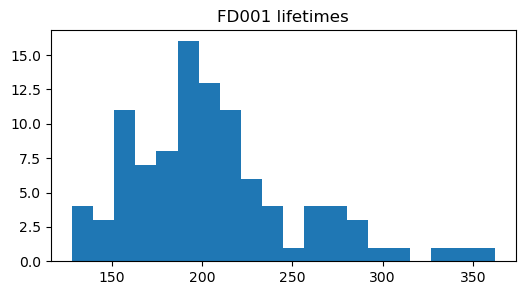

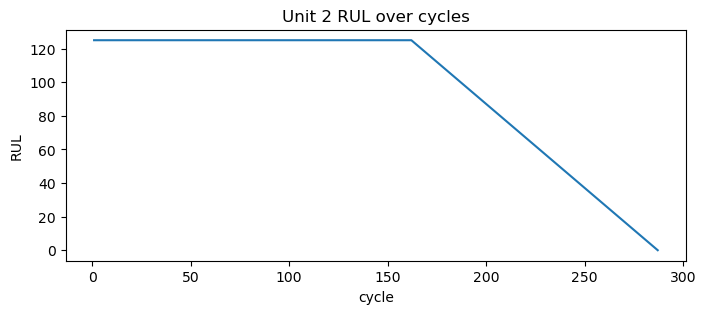

In [16]:
import matplotlib.pyplot as plt

# distribution of lifetimes (FD001)
lifetimes = loaded['FD001']['train'].groupby('unit')['cycle'].max().values
plt.figure(figsize=(6,3)); plt.hist(lifetimes, bins=20); plt.title('FD001 lifetimes'); plt.show()

# actual RUL vs cycles for one engine (unit = first in gtrain)
unit_example = gtrain[0]
df_unit = loaded['FD001']['train'][loaded['FD001']['train']['unit']==unit_example]
plt.figure(figsize=(8,3))
plt.plot(df_unit['cycle'], df_unit['RUL'], label='RUL')
plt.title(f'Unit {unit_example} RUL over cycles'); plt.xlabel('cycle'); plt.ylabel('RUL'); plt.show()


## 4. Model Architecture: Hybrid CNN-BiLSTM
We define a custom Keras model that integrates:
1.  **Conv1D Layers:** Feature extraction.
2.  **Bi-LSTM Layers:** Temporal sequence learning.
3.  **Attention Layer:** Learning widely separated dependencies.
4.  **Fully Connected Layers:** Final regression output for RUL.

In [22]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_cnn_lstm(W, n_sensors, cnn_filters=[64,128], kernel_size=3, lstm_units=128, dropout=0.3):
    inp = layers.Input(shape=(W, n_sensors))
    x = inp

    # CNN blocks
    for f in cnn_filters:
        x = layers.Conv1D(filters=f, kernel_size=kernel_size, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(pool_size=2)(x)

    # BiLSTM with L2 regularization
    x = layers.Bidirectional(
            layers.LSTM(
                lstm_units,
                return_sequences=False,
                kernel_regularizer=tf.keras.regularizers.l2(1e-4)
            )
        )(x)

    x = layers.Dropout(dropout)(x)

    # Dense with L2 regularization
    out = layers.Dense(
        1,
        activation='linear',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae']
    )

    return model

model = build_cnn_lstm(W=W, n_sensors=len(global_sensors))
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 40, 19)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 40, 64)              │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 40, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 20, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292,609 (1.12 MB)

 Trainable params: 292,225 (1.11 MB)

 Non-trainable params: 384 (1.50 KB)

In [23]:
# Check wrapper-level and inner layers' regularizers
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Bidirectional):
        print(f"{layer.name:25s}  -> wrapper.kernel_regularizer: {getattr(layer, 'kernel_regularizer', None)}")
        # forward/backward LSTM layers are attributes on the bidirectional wrapper
        f = getattr(layer, 'forward_layer', None)
        b = getattr(layer, 'backward_layer', None)
        print("  forward_layer kernel_regularizer:", getattr(f, 'kernel_regularizer', None))
        print("  backward_layer kernel_regularizer:", getattr(b, 'kernel_regularizer', None))
    else:
        print(f"{layer.name:25s}  -> kernel_regularizer: {getattr(layer, 'kernel_regularizer', None)}")


input_layer_2              -> kernel_regularizer: None
conv1d_4                   -> kernel_regularizer: None
batch_normalization_4      -> kernel_regularizer: None
max_pooling1d_4            -> kernel_regularizer: None
conv1d_5                   -> kernel_regularizer: None
batch_normalization_5      -> kernel_regularizer: None
max_pooling1d_5            -> kernel_regularizer: None
bidirectional_2            -> wrapper.kernel_regularizer: None
  forward_layer kernel_regularizer: <keras.src.regularizers.regularizers.L2 object at 0x000002520180F1D0>
  backward_layer kernel_regularizer: <keras.src.regularizers.regularizers.L2 object at 0x0000025201743740>
dropout_2                  -> kernel_regularizer: None
dense_2                    -> kernel_regularizer: <keras.src.regularizers.regularizers.L2 object at 0x00000252017437A0>


In [24]:
# Rebuild model with stronger L2 and more dropout
from tensorflow.keras import layers, models
import tensorflow as tf

def build_cnn_lstm_reg(W, n_sensors, lstm_units=128, dropout=0.5, l2_lambda=1e-3):
    inp = layers.Input(shape=(W, n_sensors))
    x = inp
    for f in [64,128]:
        x = layers.Conv1D(f, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(2)(x)
    lstm_layer = layers.LSTM(lstm_units, return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                             recurrent_regularizer=tf.keras.regularizers.l2(l2_lambda))
    x = layers.Bidirectional(lstm_layer)(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
    return model

model = build_cnn_lstm_reg(W=W, n_sensors=len(global_sensors), lstm_units=128, dropout=0.5, l2_lambda=1e-3)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 40, 19)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 40, 64)              │           3,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 40, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 20, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292,609 (1.12 MB)

 Trainable params: 292,225 (1.11 MB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
# Use AdamW optimizer (TensorFlow >=2.9)
from tensorflow.keras.optimizers import Adam
try:
    # prefer experimental AdamW if available
    from tensorflow_addons.optimizers import AdamW
    opt = AdamW(learning_rate=1e-3, weight_decay=1e-4)  # weight_decay ~ l2 strength
except Exception:
    # fallback: use built-in Adam with no explicit weight decay
    opt = tf.keras.optimizers.Adam(1e-3)

model.compile(optimizer=opt, loss='mae', metrics=['mae'])


In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_val).ravel()

# MAE
print("Val MAE:", mean_absolute_error(y_val, y_pred))

# RMSE (manual square root, compatible with old sklearn)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Val RMSE:", rmse)

# Critical-zone MAE (RUL <= 30)
def zone_mae(y_true, y_pred, thresh=30):
    mask = y_true <= thresh
    if mask.sum() == 0:
        return np.nan
    return mean_absolute_error(y_true[mask], y_pred[mask])

print("Val MAE (RUL <= 30):", zone_mae(y_val, y_pred, thresh=30))


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Val MAE: 77.36627960205078
Val RMSE: 87.86348886642989
Val MAE (RUL <= 30): 14.90182113647461


🔍 Diagnostic Analysis of RUL Prediction Errors
This cell helps inspect where the model is making mistakes.
It calculates:
MAE for different RUL ranges (e.g., 0–10, 10–20, ..., 80–125)
A scatter plot of true vs predicted RUL
The worst-performing engine units
A detailed plot of prediction vs true RUL for the worst unit

This helps us understand if the model struggles with long-term RUL, mid-range RUL, or only certain engines.


MAE by RUL bin:
0-10   : 5.336
10-20  : 15.393
20-30  : 25.446
30-50  : 40.513
50-80  : 65.580
80-125 : 113.618


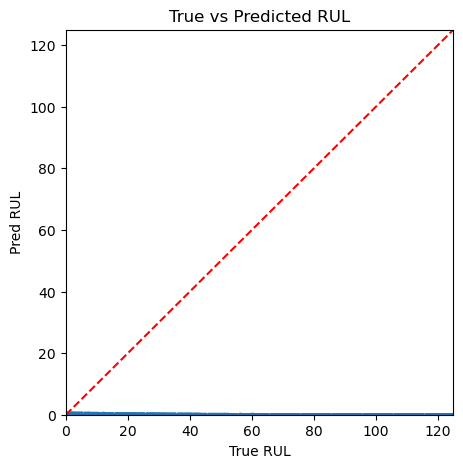

Top 5 worst units: [(np.int64(5), np.float64(90.85751425980226)), (np.int64(84), np.float64(90.5093989918466)), (np.int64(54), np.float64(88.95357506968286)), (np.int64(46), np.float64(88.84077674837157)), (np.int64(11), np.float64(85.91595994992487))]


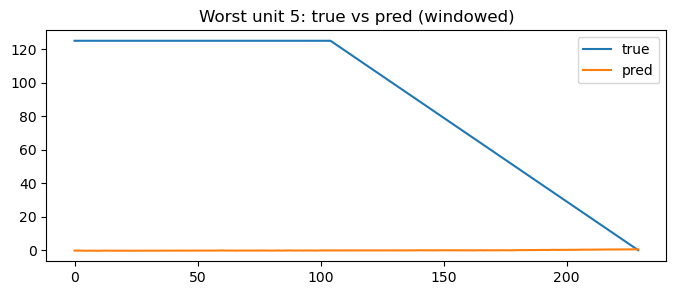

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

y_true = y_val
y_pred = y_pred  # from evaluation cell

# 1) MAE per RUL range
bins = [0, 10, 20, 30, 50, 80, 125]
bin_names = ["0-10","10-20","20-30","30-50","50-80","80-125"]
bin_maes = []
for i in range(len(bins)-1):
    mask = (y_true > bins[i]) & (y_true <= bins[i+1])
    if mask.sum():
        bin_maes.append(mean_absolute_error(y_true[mask], y_pred[mask]))
    else:
        bin_maes.append(np.nan)

print("MAE by RUL bin:")
for name, m in zip(bin_names, bin_maes):
    print(f"{name:7s}: {m:.3f}")

# 2) Scatter plot
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=6, alpha=0.3)
plt.plot([0,125],[0,125], 'r--')
plt.xlabel('True RUL'); plt.ylabel('Pred RUL'); plt.title('True vs Predicted RUL')
plt.xlim(0,125); plt.ylim(0,125); plt.show()

# 3) Worst engines
from collections import defaultdict
errs = defaultdict(list)
for u, t, p in zip(gval, y_true, y_pred):
    errs[u].append(abs(t-p))
unit_mae = {u: np.mean(v) for u,v in errs.items()}
sorted_units = sorted(unit_mae.items(), key=lambda x: x[1], reverse=True)
print("Top 5 worst units:", sorted_units[:5])

# 4) Plot worst unit
worst_unit = sorted_units[0][0]
ix = np.where(gval == worst_unit)[0]
plt.figure(figsize=(8,3))
plt.plot(y_true[ix], label='true')
plt.plot(y_pred[ix], label='pred')
plt.title(f'Worst unit {worst_unit}: true vs pred (windowed)')
plt.legend()
plt.show()


⚙️ Upgraded Model: BiLSTM with Attention (fixed)
This cell builds a CNN → BiLSTM → attention model. The attention implementation uses only Keras layers (Softmax over time) to avoid symbol/runtime incompatibilities. Attention computes a time-wise importance weight for each timestep and produces a weighted sum as the sequence summary.

In [28]:
from tensorflow.keras import layers, models
import tensorflow as tf

def attention_block(x):
    # x shape = (batch, time, features)
    # 1) score per time-step (batch, time, attn_units)
    score = layers.Dense(64, activation='tanh')(x)
    # 2) single scalar score per time-step (batch, time, 1)
    weights = layers.Dense(1)(score)
    # 3) softmax across time axis -> normalized attention weights (batch, time, 1)
    weights = layers.Softmax(axis=1)(weights)
    # 4) apply weights and sum across time -> (batch, features)
    attended = layers.Multiply()([x, weights])          # (batch, time, features)
    out = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(attended)
    return out

def build_cnn_lstm_attention(W, n_sensors, lstm_units=128, dropout=0.4, l2_lambda=1e-4):
    inp = layers.Input(shape=(W, n_sensors))
    x = inp

    # CNN feature extractor
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    # BiLSTM returns full sequence for attention
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                    recurrent_regularizer=tf.keras.regularizers.l2(l2_lambda))
    )(x)

    # Attention pooling (fixed implementation using Keras layers only)
    x = attention_block(x)

    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
    return model

# Rebuild model with current W and sensors
model = build_cnn_lstm_attention(W=W, n_sensors=len(global_sensors), lstm_units=128, dropout=0.4, l2_lambda=1e-4)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 40, 19)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 40, 64)            │           3,712 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 40, 64)            │             256 │ conv1d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_8               │ (None, 20, 64)            │               0 │ batch_normalization_8[0][… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_9 (Conv1D)             │ (None, 20, 128)           │          24,704 │ max_pooling1d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 20, 128)           │             512 │ conv1d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_9               │ (None, 10, 128)           │               0 │ batch_normalization_9[0][… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_4               │ (None, 10, 256)           │         263,168 │ max_pooling1d_9[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 10, 64)            │          16,448 │ bidirectional_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 10, 1)             │              65 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ softmax (Softmax)             │ (None, 10, 1)             │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 10, 256)           │               0 │ bidirectional_4[0][0],     │
│                               │                           │                 │ softmax[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 256)               │               0 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 256)               │               0 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 309,122 (1.18 MB)

 Trainable params: 308,738 (1.18 MB)

 Non-trainable params: 384 (1.50 KB)

🏋️ Training the Model (CNN → BiLSTM → Attention)

This cell trains the attention-based RUL prediction model using:

* Training set: X_train, y_train
* Validation set: X_val, y_val
* EarlyStopping: stops training if validation MAE stops improving
* ReduceLROnPlateau: lowers learning rate when progress stalls
* ModelCheckpoint: saves the best model to artifacts/best_model.h5

During each epoch, you will see:

* loss → training MAE
* val_loss → validation MAE
* learning_rate → current learning rate (adapts over time)

Lower values are better.
The model is considered “best” at the lowest val_loss.

In [29]:
# Training cell: uses EarlyStopping, ReduceLROnPlateau and ModelCheckpoint.
import os
from tensorflow.keras import callbacks

os.makedirs('artifacts', exist_ok=True)
checkpoint_path = 'artifacts/best_model.h5'

early = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mc = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,            # lower on CPU if needed
    batch_size=64,        # reduce to 32 or 16 if OOM
    callbacks=[early, reduce_lr, mc],
    verbose=1
)


Epoch 1/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 55.4028 - mae: 55.3252
Epoch 1: val_loss improved from None to 26.94263, saving model to artifacts/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - loss: 43.2559 - mae: 43.1725 - val_loss: 26.9426 - val_mae: 26.8540 - learning_rate: 0.0010
Epoch 2/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 22.5569 - mae: 22.4668
Epoch 2: val_loss improved from 26.94263 to 14.23224, saving model to artifacts/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - loss: 19.5651 - mae: 19.4735 - val_loss: 14.2322 - val_mae: 14.1376 - learning_rate: 0.0010
Epoch 3/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 13.6106 - mae: 13.5133
Epoch 3: val_loss improved from 14.23224 to 12.14754, saving model to artifacts/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 12.2464 - mae: 12.1469 - val_loss: 12.1475 - val_mae: 12.0444 - learning_rate: 0.0010
Epoch 4/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 10.1091 - mae: 10.0046
Epoch 4: val_loss improved from 12.14754 to 10.81768, saving model to artifacts/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 9.4252 - mae: 9.3195 - val_loss: 10.8177 - val_mae: 10.7097 - learning_rate: 0.0010
Epoch 5/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.0368 - mae: 7.9283
Epoch 5: val_loss did not improve from 10.81768
211/211 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 7.8560 - mae: 7.7468 - val_loss: 11.6360 - val_mae: 11.5256 - learning_rate: 0.0010
Epoch 6/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 7.2319 - mae: 7.1207
Epoch 6: val_loss improved from 10.81768 to 9.71864, saving model to artifacts/best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 7.1410 - mae: 7.0292 - val_loss: 9.7186 - val_mae: 9.6053 - learning_rate: 0.0010
Epoch 7/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 6.7740 - mae: 6.6592
Epoch 7: val_loss did not improve from 9.71864
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 6.5660 - mae: 6.4507 - val_loss: 10.0466 - val_mae: 9.9304 - learning_rate: 0.0010
Epoch 8/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 6.2352 - mae: 6.1181
Epoch 8: val_loss did not improve from 9.71864
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 6.0285 - mae: 5.9109 - val_loss: 10.5774 - val_mae: 10.4589 - learning_rate: 0.0010
Epoch 9/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 5.7269 - mae: 5.6081
Epoch 9: val_loss did not improve from 9.71864
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 5.7593 - mae: 5.6401 - val_loss: 10.3869 - val_mae: 10.2667 - learning_rate: 0.0010
Epoch 10/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 5.6481 - mae: 

📈 Validation Evaluation & Diagnostics
This cell computes MAE/RMSE on the validation set, prints MAE for the critical zone (RUL ≤ 30), shows the train/val curves if available, and plots true vs predicted points. 
It helps measure model generalization and whether more tuning is needed.

103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Validation MAE: 9.6053
Validation RMSE: 14.1090
Validation MAE (RUL <= 30): 4.713040828704834


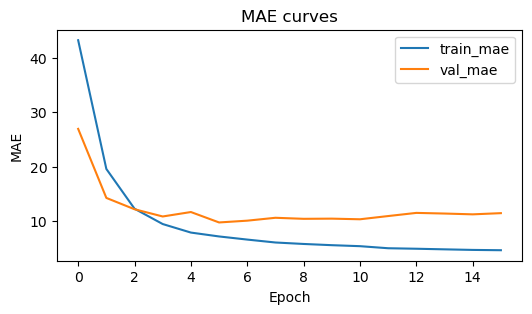

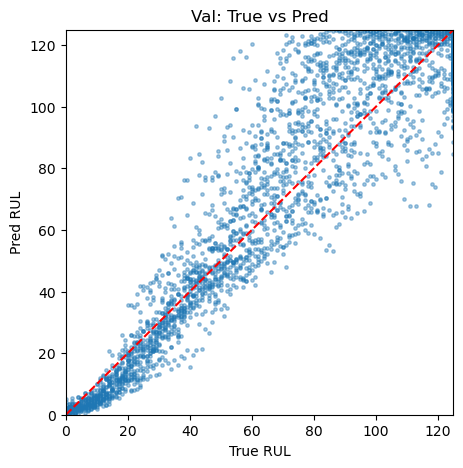

Top 3 worst units (val): [(np.int64(74), np.float64(21.937347047910915)), (np.int64(77), np.float64(19.37104624250661)), (np.int64(45), np.float64(17.82236723038329))]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# load best weights (already restored by EarlyStopping if used, but safe to load)
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

# Predict on validation
y_pred_val = model.predict(X_val).ravel()
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MAE: {mae_val:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

# zone MAE for RUL <= 30
def zone_mae(y_true, y_pred, thresh=30):
    mask = y_true <= thresh
    return mean_absolute_error(y_true[mask], y_pred[mask]) if mask.sum()>0 else np.nan

print("Validation MAE (RUL <= 30):", zone_mae(y_val, y_pred_val, thresh=30))

# Plot train/val MAE curves if history exists
if 'history' in globals():
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train_mae')
    plt.plot(history.history['val_loss'], label='val_mae')
    plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE curves'); plt.show()

# True vs Pred scatter
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_pred_val, s=6, alpha=0.4)
plt.plot([0,125],[0,125], 'r--')
plt.xlabel('True RUL'); plt.ylabel('Pred RUL'); plt.title('Val: True vs Pred')
plt.xlim(0,125); plt.ylim(0,125);plt.savefig("artifacts/training_curve_mae_valmae.png", dpi=300)
plt.show()

# Show top-3 worst units by MAE on val
from collections import defaultdict
errs = defaultdict(list)
for unit, t, p in zip(gval, y_val, y_pred_val):
    errs[unit].append(abs(t-p))
unit_mae = {u: np.mean(v) for u,v in errs.items()}
worst = sorted(unit_mae.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 worst units (val):", worst)


🧪 Test-Set Inference & PHM Score (FD001)
This cell builds the last-cycle test windows for FD001 (window length W — must match training), runs inference with the saved best model, computes Test MAE & RMSE, computes the PHM score (penalizes late predictions harder), and shows diagnostics:

* Test MAE & RMSE
* PHM total (lower is better) and histogram of per-unit PHM terms
* Scatter plot (true vs predicted RUL for test windows)
* Per-unit table sorted by absolute error (worst first)

Loaded weights from: artifacts/best_model.h5
Test windows shape: (100, 40, 19) Num units: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test MAE (FD001): 14.2390
Test RMSE (FD001): 18.4273
PHM score (total): 746.4707
PHM score (mean per unit): 7.4647


,unit,y_true,y_pred,abs_err,phm_term
0,79,63,118.394753,55.394753,253.544392
1,45,114,66.571648,47.428352,37.410651
2,93,85,38.880817,46.119183,33.730888
3,73,131,90.322945,40.677055,21.851214
4,55,137,100.112099,36.887901,16.073557
5,27,66,102.391518,36.391518,37.059540
6,15,83,118.272346,35.272346,33.029733
7,67,77,108.456917,31.456917,22.235742
8,47,135,104.495796,30.504204,9.448696
9,4,82,112.019005,30.019005,19.123745


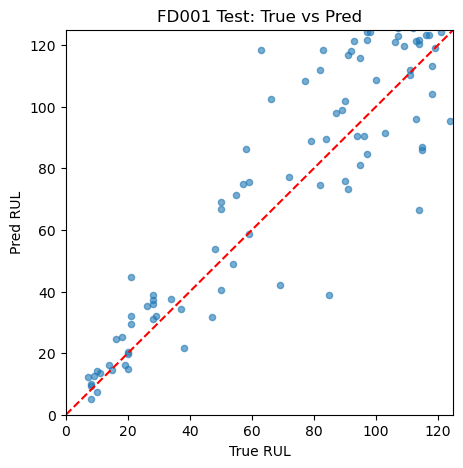

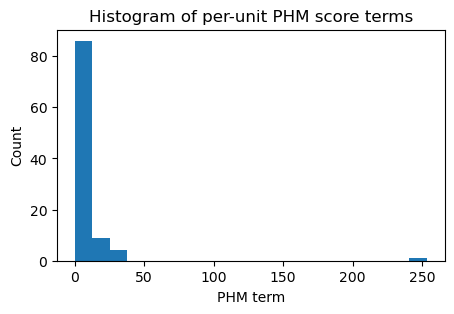

Saved per-unit test predictions to: artifacts/FD001_test_predictions.csv


In [38]:
# Test-set evaluation (FD001) with PHM score and diagnostics

from sklearn.metrics import mean_absolute_error, mean_squared_error

fd = 'FD001'

# Basic checks
if fd not in loaded or loaded[fd].get('test') is None or loaded[fd].get('rul') is None:
    raise ValueError(f"{fd} test or RUL file not loaded in `loaded` dict")

test_df = loaded[fd]['test'].copy().sort_values(['unit','cycle']).reset_index(drop=True)
rul_df = loaded[fd]['rul'].copy().reset_index(drop=True)  # one row per unit, recommended by CMAPSS

# If you saved model as .keras (recommended) or .h5, load weights if checkpoint exists
# checkpoint_path variable may exist from training; fallback to artifacts/best_model.keras or .h5
cp_candidates = []
if 'checkpoint_path' in globals():
    cp_candidates.append(checkpoint_path)
cp_candidates += [
    'artifacts/best_model.keras',
    'artifacts/best_model.h5',
    'artifacts/best_model.keras',
    'artifacts/best_model'
]
loaded_cp = None
for p in cp_candidates:
    if p and os.path.exists(p):
        loaded_cp = p
        try:
            # if it's a folder saved by model.save('folder'), load_model works too
            model.load_weights(p)
        except Exception:
            # ignore load errors — model may already have weights loaded
            pass
        break

if loaded_cp:
    print("Loaded weights from:", loaded_cp)
else:
    print("No checkpoint found in expected locations; using current model state.")

# Helper: build last-window per unit
def make_last_windows_for_test(test_df, sensors, W=40):
    units = sorted(test_df['unit'].unique())
    X_test = []
    for u in units:
        g = test_df[test_df['unit']==u].sort_values('cycle')
        arr = g[sensors].values
        if len(arr) < W:
            pad = np.repeat(arr[:1], W - len(arr), axis=0)
            arrp = np.vstack([pad, arr])
        else:
            arrp = arr[-W:]
        X_test.append(arrp)
    return np.array(X_test), np.array(units)

# Create test windows using same W as training (if you changed to 60, ensure W variable reflects that)
if 'W' not in globals():
    print("Warning: W (window length) not set in environment. Using default W=40.")
    W = 40

X_test, test_units = make_last_windows_for_test(test_df, global_sensors, W=W)
print("Test windows shape:", X_test.shape, "Num units:", len(test_units))

# Predict
y_test_pred = model.predict(X_test).ravel()
y_test_true = rul_df['RUL'].values  # CMAPSS RUL file is aligned by unit order

# Basic metrics
mae_test = mean_absolute_error(y_test_true, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
print(f"Test MAE (FD001): {mae_test:.4f}")
print(f"Test RMSE (FD001): {rmse_test:.4f}")

# PHM score calculation (per-unit d = pred - true)
d = y_test_pred - y_test_true
# per-unit PHM terms
score_terms = np.where(d < 0, np.exp(-d/13.0) - 1.0, np.exp(d/10.0) - 1.0)
phm_score_total = np.sum(score_terms)
print(f"PHM score (total): {phm_score_total:.4f}")
print(f"PHM score (mean per unit): {np.mean(score_terms):.4f}")

# Diagnostics: table of per-unit results sorted by absolute error
df_compare = pd.DataFrame({
    'unit': test_units,
    'y_true': y_test_true,
    'y_pred': y_test_pred,
    'abs_err': np.abs(y_test_pred - y_test_true),
    'phm_term': score_terms
})
df_sorted = df_compare.sort_values('abs_err', ascending=False).reset_index(drop=True)
display(df_sorted.head(12))

# Scatter plot: true vs pred
plt.figure(figsize=(5,5))
plt.scatter(y_test_true, y_test_pred, s=20, alpha=0.6)
plt.plot([0,125],[0,125], 'r--')
plt.xlabel('True RUL'); plt.ylabel('Pred RUL'); plt.title(f'{fd} Test: True vs Pred')
plt.xlim(0,125); plt.ylim(0,125); plt.show()

# Histogram of PHM terms
plt.figure(figsize=(5,3))
plt.hist(score_terms, bins=20)
plt.title('Histogram of per-unit PHM score terms')
plt.xlabel('PHM term'); plt.ylabel('Count'); plt.show()

# Save per-unit results to CSV for reporting
out_csv = f'artifacts/{fd}_test_predictions.csv'
df_sorted.to_csv(out_csv, index=False)
print("Saved per-unit test predictions to:", out_csv)


Run full pipeline on FD001–FD004
This cell trains a separate model for each FD set (FD001, FD002, FD003, FD004) using the same model architecture and window length W. It saves per-FD test predictions and a combined results CSV with MAE, RMSE, PHM total and PHM mean.
Note: ensure loaded dict, global_sensors, and W are present in the notebook environment (they should be if you ran earlier cells).

## 5. Model Training
Training the model on all 4 datasets (FD001-FD004) using:
* **Loss Function:** Mean Absolute Error (MAE).
* **Optimizer:** Adam.
* **Callbacks:** EarlyStopping and ModelCheckpoint to save the best-performing weights.

In [ ]:
# ============================================================
# Run this cell to train & evaluate FD001-FD004 sequentially.
# IMPORTANT: set RUN_TRAINING = False in the PARAMETERS cell
# to avoid long retraining when opening the notebook (safe default).
# ============================================================

import os, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import callbacks

# ------------------ USER / TOP-PARAMETERS (override in top PARAMETERS cell) -----------------

# If not found below, default to False to be safe.
RUN_TRAINING = globals().get('RUN_TRAINING', False)
FD_LIST = globals().get('FD_LIST', ['FD001','FD002','FD003','FD004'])
EPOCHS = globals().get('EPOCHS', 80)          # early stopping will usually stop earlier
BATCH_SIZE = globals().get('BATCH_SIZE', 64)
VAL_FRAC = globals().get('VAL_FRAC', 0.2)
W_local = globals().get('W', 40)  # use W from environment if present
ARTIFACTS_DIR = globals().get('ARTIFACTS_DIR', 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
# ----------------------------------------------------------------------------------------------

print(f"RUN_TRAINING={RUN_TRAINING}  |  EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, W={W_local}")

# Reuse model builder you used (attention model). If you defined it as build_cnn_lstm_attention, use it.
try:
    build_model_fn = build_cnn_lstm_attention
except NameError:
    # fallback builder (only used if you never defined build_cnn_lstm_attention)
    from tensorflow.keras import layers, models
    import tensorflow as tf
    def build_cnn_lstm_attention(W, n_sensors, lstm_units=128, dropout=0.4, l2_lambda=1e-4):
        inp = layers.Input(shape=(W, n_sensors))
        x = layers.Conv1D(64,3,padding='same',activation='relu')(inp)
        x = layers.BatchNormalization()(x); x = layers.MaxPool1D(2)(x)
        x = layers.Conv1D(128,3,padding='same',activation='relu')(x)
        x = layers.BatchNormalization()(x); x = layers.MaxPool1D(2)(x)
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True,
                                             kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                                             recurrent_regularizer=tf.keras.regularizers.l2(l2_lambda)))(x)
        # attention
        score = layers.Dense(64, activation='tanh')(x)
        weights = layers.Dense(1)(score); weights = layers.Softmax(axis=1)(weights)
        attended = layers.Multiply()([x, weights])
        out = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(attended)
        out = layers.Dropout(dropout)(out)
        out = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(out)
        model = models.Model(inp, out)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
        return model
    build_model_fn = build_cnn_lstm_attention

results = []
for fd in FD_LIST:
    print("\n\n" + "="*60)
    print("Processing", fd)
    if fd not in loaded:
        print(f"  SKIP: {fd} not found in loaded dict.")
        continue
    # check presence
    train_df = loaded[fd].get('train')
    test_df = loaded[fd].get('test')
    rul_df = loaded[fd].get('rul')
    if train_df is None or test_df is None or rul_df is None:
        print(f"  SKIP: missing train/test/rul for {fd}. train:{train_df is not None}, test:{test_df is not None}, rul:{rul_df is not None}")
        continue

    # Prepare windows for training
    print("  Generating windows (W=%d)..." % W_local)
    X, y, units = make_windows(train_df, global_sensors, W=W_local, stride=1)
    print("   total windows:", X.shape)

    # Group split train/val
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=VAL_FRAC, random_state=42)
    tr_idx, val_idx = next(gss.split(X, y, groups=units))
    X_train, y_train = X[tr_idx], y[tr_idx]
    X_val, y_val, gtrain, gval = X[val_idx], y[val_idx], units[tr_idx], units[val_idx]
    print("   Train windows:", X_train.shape, "Val windows:", X_val.shape)

    # Build model
    model = build_model_fn(W_local, n_sensors=len(global_sensors))
    checkpoint_path = os.path.join(ARTIFACTS_DIR, f'best_model_{fd}.keras')
    mc = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    early = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train (only if explicitly enabled)
    if RUN_TRAINING:
        print("  TRAINING ENABLED: training model for", fd)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early, reduce_lr, mc],
            verbose=1
        )
        # ensure weights loaded from checkpoint if present
        if os.path.exists(checkpoint_path):
            try:
                model.load_weights(checkpoint_path)
            except Exception:
                pass
    else:
        # Evaluation mode: attempt to load existing checkpoint; if absent, skip
        if os.path.exists(checkpoint_path):
            try:
                model.load_weights(checkpoint_path)
                print("  Loaded existing checkpoint for", fd)
            except Exception:
                print("  Could not load checkpoint for", fd)
        else:
            print(f"  No checkpoint found for {fd}. Skipping training because RUN_TRAINING=False.")
            continue

    # Evaluate on validation (quick)
    y_val_pred = model.predict(X_val).ravel()
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Prepare test windows: last-window per unit
    test_df_sorted = test_df.sort_values(['unit','cycle']).reset_index(drop=True)
    def make_last_windows_for_test(test_df_local, sensors, W=W_local):
        units_local = sorted(test_df_local['unit'].unique())
        X_test_local = []
        for u in units_local:
            g = test_df_local[test_df_local['unit']==u].sort_values('cycle')
            arr = g[sensors].values
            if len(arr) < W:
                pad = np.repeat(arr[:1], W - len(arr), axis=0)
                arrp = np.vstack([pad, arr])
            else:
                arrp = arr[-W:]
            X_test_local.append(arrp)
        return np.array(X_test_local), np.array(units_local)

    X_test, test_units = make_last_windows_for_test(test_df_sorted, global_sensors, W=W_local)
    print(f"  Test windows shape: {X_test.shape}, Num units: {len(test_units)}")

    y_test_pred = model.predict(X_test).ravel()
    y_test_true = rul_df['RUL'].values

    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # PHM score
    d = y_test_pred - y_test_true
    score_terms = np.where(d < 0, np.exp(-d/13.0) - 1.0, np.exp(d/10.0) - 1.0)
    phm_total = np.sum(score_terms)
    phm_mean = np.mean(score_terms)

    # Save per-unit dataframe
    df_compare = pd.DataFrame({
        'unit': test_units,
        'y_true': y_test_true,
        'y_pred': y_test_pred,
        'abs_err': np.abs(y_test_pred - y_test_true),
        'phm_term': score_terms
    })
    out_csv = os.path.join(ARTIFACTS_DIR, f'{fd}_test_predictions.csv')
    df_compare.sort_values('abs_err', ascending=False).to_csv(out_csv, index=False)

    print(f"  Test MAE ({fd}): {mae_test:.4f}")
    print(f"  Test RMSE ({fd}): {rmse_test:.4f}")
    print(f"  PHM score (total): {phm_total:.4f}  mean per unit: {phm_mean:.4f}")
    print(f"  Saved per-unit results to: {out_csv}")

    # Append summary
    results.append({
        'fd': fd,
        'val_mae': float(val_mae),
        'val_rmse': float(val_rmse),
        'test_mae': float(mae_test),
        'test_rmse': float(rmse_test),
        'phm_total': float(phm_total),
        'phm_mean': float(phm_mean),
        'n_test_units': int(len(test_units))
    })

# Combined results
df_results = pd.DataFrame(results)
out_summary = os.path.join(ARTIFACTS_DIR, 'combined_FD_results.csv')
df_results.to_csv(out_summary, index=False)
print("\nAll done. Combined results saved to:", out_summary)
display(df_results)




Processing FD001
  Generating windows (W=40)...
   total windows: (16731, 40, 19)
   Train windows: (13441, 40, 19) Val windows: (3290, 40, 19)
  Training model for FD001
Epoch 1/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 55.8071 - mae: 55.7294
Epoch 1: val_loss improved from None to 27.60496, saving model to artifacts/best_model_FD001.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - loss: 43.5659 - mae: 43.4823 - val_loss: 27.6050 - val_mae: 27.5157 - learning_rate: 0.0010
Epoch 2/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 22.6851 - mae: 22.5944
Epoch 2: val_loss improved from 27.60496 to 14.42595, saving model to artifacts/best_model_FD001.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - loss: 19.6581 - mae: 19.5663 - val_loss: 14.4260 - val_mae: 14.3320 - learning_rate: 0.0010
Epoch 3/80
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 13.5975 - mae: 13.5022
Epoch 3: val_loss improved from 14.42595 to 11.80274, saving model to artifacts/best_model_FD001

In [2]:
# --- Cell 1: minimal imports and reload dataset from disk ---
import os, glob, numpy as np, pandas as pd, json
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# <-- EDIT this if your data folder is somewhere else -->
DATA_DIR = r"C:\Users\Rasleen Kaur\Desktop\Engine Health Prediction\data"
if not os.path.exists(DATA_DIR):
    print("Warning: DATA_DIR not found:", DATA_DIR)
    DATA_DIR = "data"  # fallback

# loader function (same as earlier)
def load_cmapss(path):
    colnames = ["unit","cycle"] + [f"op_{i}" for i in range(1,4)] + [f"s{i}" for i in range(1,22)]
    return pd.read_csv(path, sep=r'\s+', header=None, names=colnames)

def auto_load_cmapss(data_dir=DATA_DIR):
    files = os.listdir(data_dir)
    mapping = {fd: {'train':None,'test':None,'rul':None} for fd in ["FD001","FD002","FD003","FD004"]}
    for f in files:
        fname = f.lower()
        for fd in mapping:
            if fd.lower() in fname:
                if 'train' in fname: mapping[fd]['train'] = os.path.join(data_dir, f)
                elif 'test' in fname: mapping[fd]['test'] = os.path.join(data_dir, f)
                elif 'rul' in fname: mapping[fd]['rul'] = os.path.join(data_dir, f)
    loaded = {}
    for fd, paths in mapping.items():
        if any(paths.values()):
            loaded[fd] = {}
            if paths['train'] is not None: loaded[fd]['train'] = load_cmapss(paths['train'])
            if paths['test'] is not None: loaded[fd]['test']  = load_cmapss(paths['test'])
            if paths['rul'] is not None:  loaded[fd]['rul']   = pd.read_csv(paths['rul'], header=None, names=['RUL'])
    return loaded

# reload data
loaded = auto_load_cmapss(DATA_DIR)
print("Detected datasets:", list(loaded.keys()))

# rebuild scaler & sensors (we used FD001 earlier)
def prepare_scaler_and_sensors(train_df):
    SENSOR_COLS = [c for c in train_df.columns if c.startswith('s')]
    const_sensors = [c for c in SENSOR_COLS if train_df[c].var() == 0]
    sensors = [c for c in SENSOR_COLS if c not in const_sensors]
    scaler = StandardScaler()
    scaler.fit(train_df[sensors])
    return scaler, sensors

if 'FD001' in loaded and loaded['FD001'].get('train') is not None:
    global_scaler, global_sensors = prepare_scaler_and_sensors(loaded['FD001']['train'])
else:
    # fallback to first available train set
    for fd,d in loaded.items():
        if d.get('train') is not None:
            global_scaler, global_sensors = prepare_scaler_and_sensors(d['train'])
            break

print("Using sensors:", global_sensors)
# scale the test sets (we only need tests for evaluation)
for fd,d in loaded.items():
    for key in ['test','train']:
        if d.get(key) is not None:
            d[key] = d[key].copy()
            d[key][global_sensors] = global_scaler.transform(d[key][global_sensors])


Detected datasets: ['FD001', 'FD002', 'FD003', 'FD004']
Using sensors: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']


In [3]:
# --- Cell 2: rebuild model builder (must match what you trained earlier) ---
def attention_block(x):
    score = layers.Dense(64, activation='tanh')(x)
    weights = layers.Dense(1)(score)
    weights = layers.Softmax(axis=1)(weights)
    attended = layers.Multiply()([x, weights])
    out = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(attended)
    return out

def build_cnn_lstm_attention(W, n_sensors, lstm_units=128, dropout=0.4, l2_lambda=1e-4):
    inp = layers.Input(shape=(W, n_sensors))
    x = inp
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPool1D(2)(x)
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                    recurrent_regularizer=tf.keras.regularizers.l2(l2_lambda))
    )(x)
    x = attention_block(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
    return model

print("Model builder ready.")


Model builder ready.


In [4]:
# --- Cell 3: instantiate model, load checkpoint, evaluate FD004 ---
import glob, os
fd = 'FD004'
W_local = globals().get('W', 40)   # set to the same W you trained with (change if needed)

# create model instance
model = build_cnn_lstm_attention(W_local, n_sensors=len(global_sensors))
print("Model instantiated. W:", W_local, "n_sensors:", len(global_sensors))

# find checkpoint file (prefer .keras)
candidates = glob.glob('artifacts/best_model_FD004.keras') + glob.glob('artifacts/best_model_FD004.*') + glob.glob('artifacts/*FD004*')
cp = candidates[0] if candidates else None
print("Checkpoint candidate:", cp)

if cp:
    try:
        model.load_weights(cp)
        print("Loaded weights from", cp)
    except Exception as e:
        print("Failed to load weights:", e)
        # attempt to load any other file in artifacts
        other = glob.glob('artifacts/*FD004*') + glob.glob('artifacts/*best_model*FD004*')
        if other:
            try:
                model.load_weights(other[0])
                print("Loaded weights from fallback", other[0])
            except Exception as e2:
                print("Fallback load also failed:", e2)

# now evaluate test set
test_df = loaded[fd]['test'].copy().sort_values(['unit','cycle']).reset_index(drop=True)
rul_df = loaded[fd]['rul'].copy().reset_index(drop=True)

# build last-window test matrix
def make_last_windows_for_test(test_df_local, sensors, W=W_local):
    units_local = sorted(test_df_local['unit'].unique())
    X_test_local = []
    for u in units_local:
        g = test_df_local[test_df_local['unit']==u].sort_values('cycle')
        arr = g[sensors].values
        if len(arr) < W:
            pad = np.repeat(arr[:1], W - len(arr), axis=0)
            arrp = np.vstack([pad, arr])
        else:
            arrp = arr[-W:]
        X_test_local.append(arrp)
    return np.array(X_test_local), np.array(units_local)

X_test, test_units = make_last_windows_for_test(test_df, global_sensors, W=W_local)
print("Test windows shape:", X_test.shape, "Num units:", len(test_units))

y_test_pred = model.predict(X_test).ravel()
y_test_true = rul_df['RUL'].values

mae_test = mean_absolute_error(y_test_true, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
d = y_test_pred - y_test_true
score_terms = np.where(d < 0, np.exp(-d/13.0)-1.0, np.exp(d/10.0)-1.0)
phm_total = np.sum(score_terms); phm_mean = np.mean(score_terms)

print(f"FD004 Test MAE: {mae_test:.4f}")
print(f"FD004 Test RMSE: {rmse_test:.4f}")
print("PHM total:", phm_total, "PHM mean per unit:", phm_mean)

out = 'artifacts/FD004_test_predictions_recovered.csv'
pd.DataFrame({'unit': test_units, 'y_true': y_test_true, 'y_pred': y_test_pred, 'abs_err': np.abs(y_test_pred-y_test_true)}).to_csv(out, index=False)
print("Saved per-unit predictions to", out)



Model instantiated. W: 40 n_sensors: 19
Checkpoint candidate: artifacts/best_model_FD004.keras


C:\Users\Rasleen Kaur\Downloads\minicodainstall\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded weights from artifacts/best_model_FD004.keras
Test windows shape: (248, 40, 19) Num units: 248
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
FD004 Test MAE: 31.7185
FD004 Test RMSE: 38.5400
PHM total: 37499.30450114941 PHM mean per unit: 151.2068729885057
Saved per-unit predictions to artifacts/FD004_test_predictions_recovered.csv


In [5]:
# ============================================================
# Combined Summary for FD001 – FD004
# ============================================================

import pandas as pd
import numpy as np
import glob, os
from sklearn.metrics import mean_absolute_error, mean_squared_error

datasets = ["FD001", "FD002", "FD003", "FD004"]
summary = []

for fd in datasets:
    # Find prediction file
    pattern = f"artifacts/{fd}_test_predictions*"
    files = glob.glob(pattern)

    if len(files) == 0:
        print(f"No file found for {fd}, skipping.")
        continue

    csv_path = files[-1]  # latest file
    df = pd.read_csv(csv_path)

    mae = df["abs_err"].mean()
    rmse = np.sqrt(((df["abs_err"])**2).mean())

    # Compute PHM score again for consistency
    d = df["y_pred"] - df["y_true"]
    phm_terms = np.where(
        d < 0,
        np.exp(-d/13.0) - 1.0,
        np.exp(d/10.0) - 1.0
    )

    phm_total = phm_terms.sum()
    phm_mean = phm_terms.mean()

    summary.append([fd, mae, rmse, phm_total, phm_mean])

combined_df = pd.DataFrame(summary, columns=[
    "Dataset",
    "Test MAE",
    "Test RMSE",
    "PHM Score (Total)",
    "PHM Score (Mean per unit)"
])

print("\n=== Combined Results Table ===\n")
print(combined_df)

combined_df.to_csv("artifacts/combined_results.csv", index=False)
print("\nSaved combined summary to artifacts/combined_results.csv")



=== Combined Results Table ===

  Dataset   Test MAE  Test RMSE  PHM Score (Total)  PHM Score (Mean per unit)
0   FD001  13.908098  18.955391        1337.375930                  13.373759
1   FD002  28.239203  39.128389      394366.106945                1522.649062
2   FD003  11.269252  15.557879         516.844172                   5.168442
3   FD004  31.718477  38.540037       37499.308152                 151.206888

Saved combined summary to artifacts/combined_results.csv


In [32]:
# Quick evaluation cell — safe & fast
import os, glob
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

fd = 'FD004'   # change to FD001..FD004
ckpt_candidates = glob.glob('artifacts/best_model_*.keras') + glob.glob('artifacts/*.h5')
if not ckpt_candidates:
    print("No checkpoint found in artifacts/. Run scripts/download_weights.sh to fetch checkpoints.")
else:
    ckpt = [p for p in ckpt_candidates if fd in p]
    if not ckpt:
        ckpt = ckpt_candidates[0]
    else:
        ckpt = ckpt[0]
    print("Loading checkpoint:", ckpt)

    # build or load model - if you saved full model you can load directly
    try:
        model = tf.keras.models.load_model(ckpt)
    except Exception:
        # fallback: if you only saved weights, recreate model with your build_model() and load_weights()
        print("Could not load full model; please ensure you either saved the full model or provide build_model() in the notebook.")
        model = None

    # load test data from 'loaded' dict (assumes you already have loaded)
    if 'loaded' not in globals() or fd not in loaded:
        raise ValueError("Please run the data-loading cell to populate 'loaded' dict first.")

    test_df = loaded[fd]['test'].copy().sort_values(['unit','cycle']).reset_index(drop=True)
    rul_df = loaded[fd]['rul'].copy().reset_index(drop=True)

    # sensors list
    sensors = globals().get('global_sensors', [c for c in test_df.columns if c.startswith('s')])
    W_local = globals().get('W', 40)

    # build last-window
    def make_last_windows(test_df_local, sensors, W=W_local):
        units = sorted(test_df_local['unit'].unique())
        X_test = []
        for u in units:
            g = test_df_local[test_df_local['unit']==u].sort_values('cycle')
            arr = g[sensors].values
            if len(arr) < W:
                pad = np.repeat(arr[:1], W - len(arr), axis=0)
                arrp = np.vstack([pad, arr])
            else:
                arrp = arr[-W:]
            X_test.append(arrp)
        return np.array(X_test), np.array(units)

    X_test, test_units = make_last_windows(test_df, sensors, W=W_local)
    print("Test shape:", X_test.shape)

    if model is not None:
        y_pred = model.predict(X_test).ravel()
        y_true = rul_df['RUL'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"{fd} MAE: {mae:.4f}  RMSE: {rmse:.4f}")


Loading checkpoint: artifacts\best_model_FD004.keras
Could not load full model; please ensure you either saved the full model or provide build_model() in the notebook.
Test shape: (248, 40, 19)


## 6. Evaluation & Diagnostics
Assessing model performance on the unseen Test set.
* **Metrics:** RMSE (Root Mean Squared Error) and PHM Score (Prognostics Health Management score).
* **Visualizations:** Comparing Predicted RUL vs. True RUL to identify model bias.

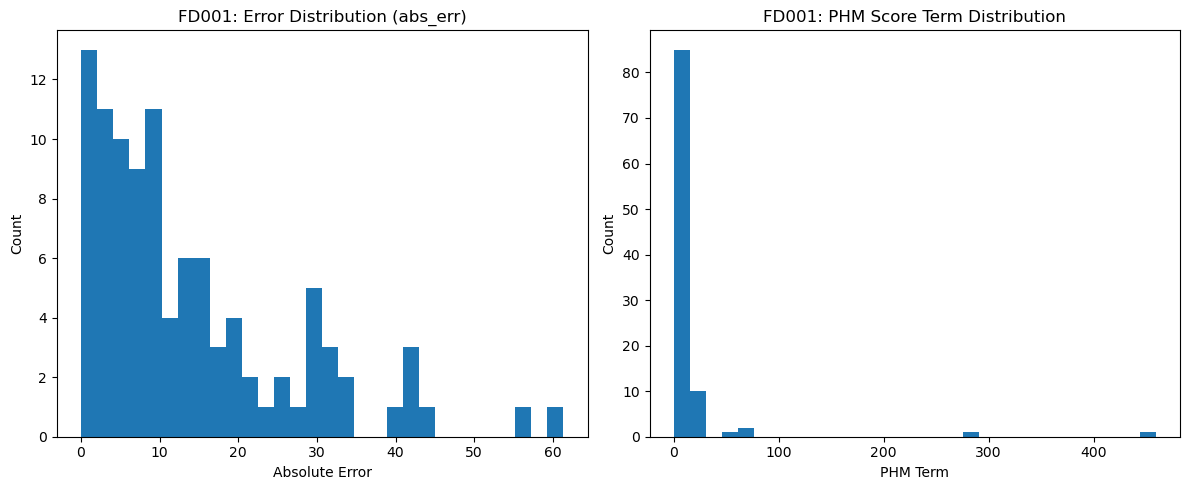

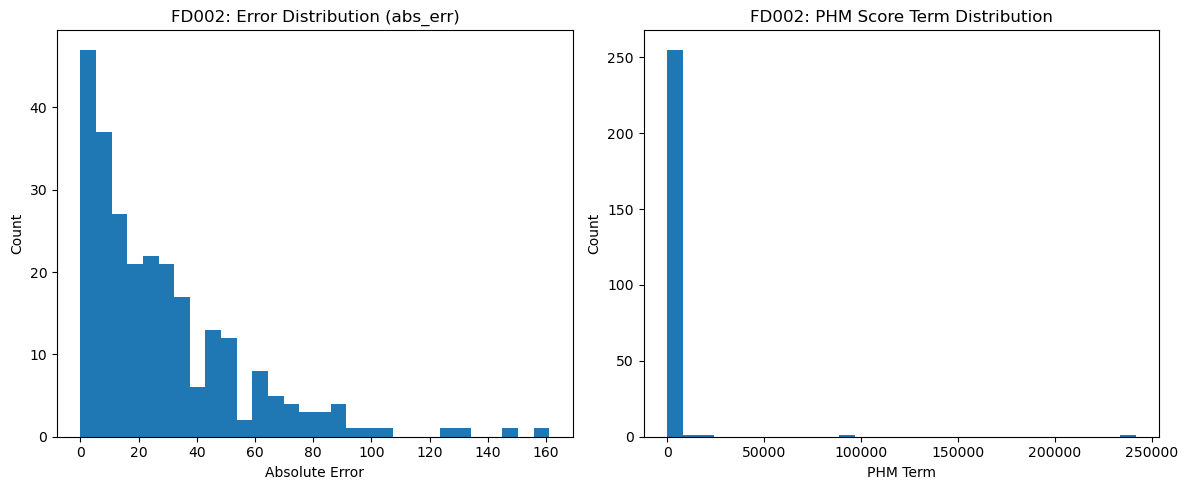

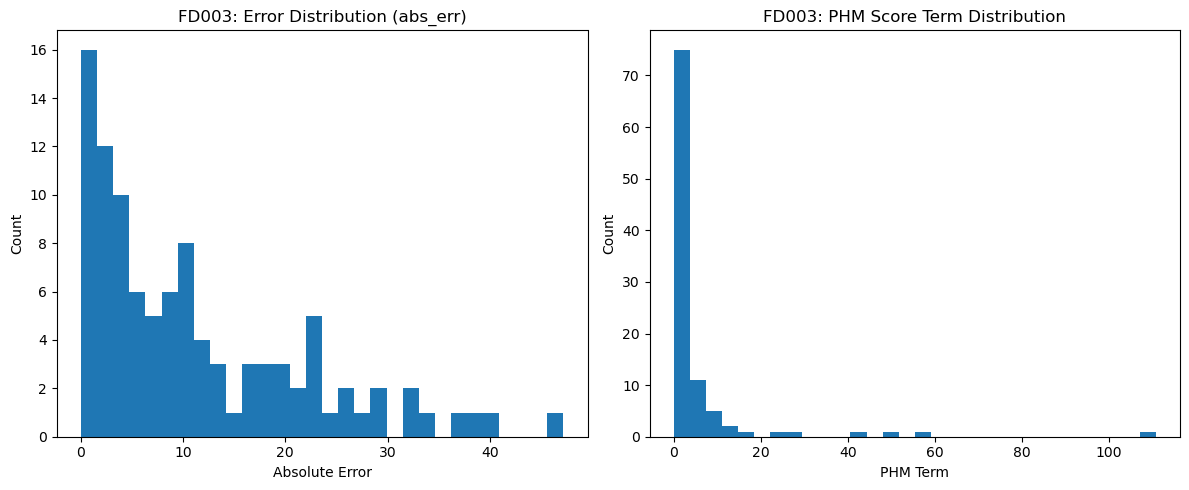

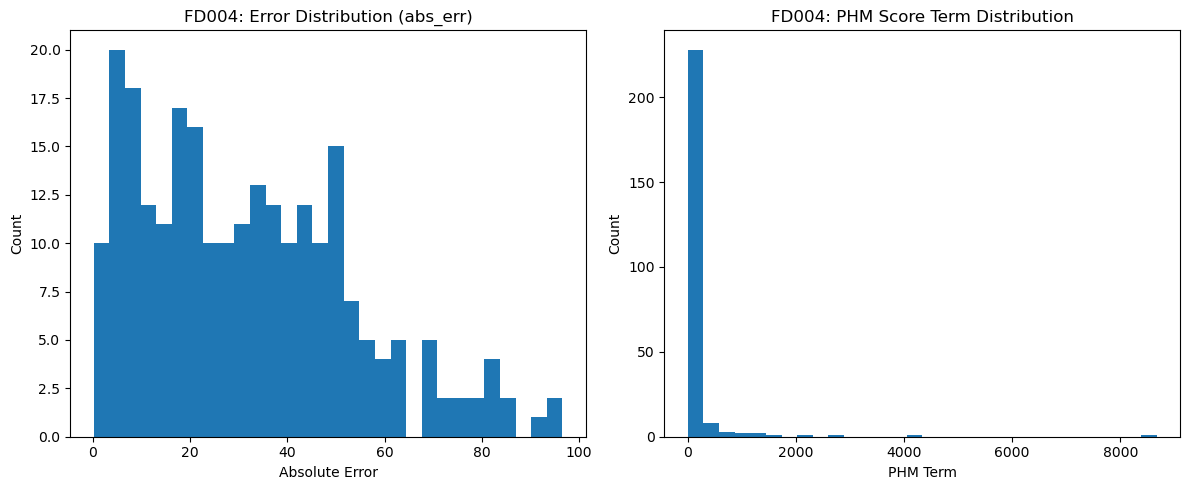

In [6]:
# ============================================================
# Error Histograms + PHM Score Histograms for all datasets
# ============================================================

import matplotlib.pyplot as plt

for fd in ["FD001", "FD002", "FD003", "FD004"]:
    pattern = f"artifacts/{fd}_test_predictions*"
    files = glob.glob(pattern)
    if not files:
        continue

    df = pd.read_csv(files[-1])

    # Errors
    errors = df["abs_err"]
    d = df["y_pred"] - df["y_true"]
    phm_terms = np.where(
        d < 0,
        np.exp(-d/13) - 1,
        np.exp(d/10) - 1
    )

    plt.figure(figsize=(12,5))

    # Left plot: Error histogram
    plt.subplot(1,2,1)
    plt.hist(errors, bins=30)
    plt.title(f"{fd}: Error Distribution (abs_err)")
    plt.xlabel("Absolute Error")
    plt.ylabel("Count")

    # Right plot: PHM term histogram
    plt.subplot(1,2,2)
    plt.hist(phm_terms, bins=30)
    plt.title(f"{fd}: PHM Score Term Distribution")
    plt.xlabel("PHM Term")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


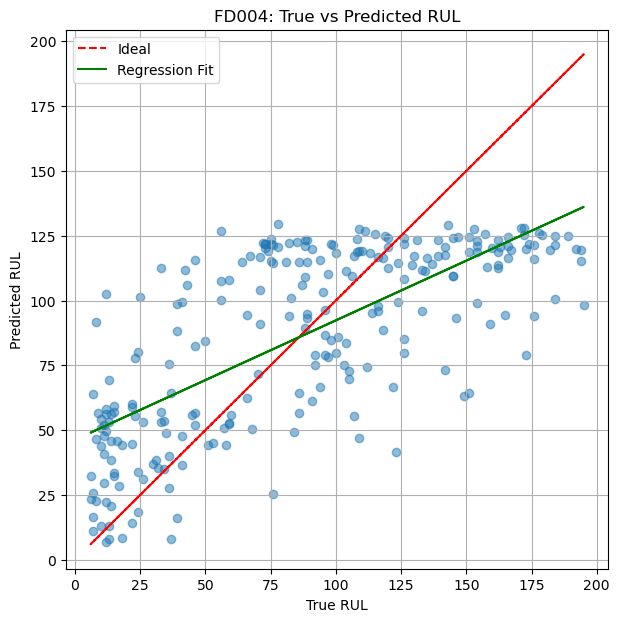

Fit slope: 0.46071674772567245
Fit intercept: 46.26948134745339


In [7]:
# ============================================================
# FD004 True vs Pred (Regression Fit)
# ============================================================

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_csv("artifacts/FD004_test_predictions_recovered.csv")

X = df["y_true"].values.reshape(-1,1)
y = df["y_pred"].values

reg = LinearRegression().fit(X, y)
line = reg.predict(X)

plt.figure(figsize=(7,7))
plt.scatter(df["y_true"], df["y_pred"], alpha=0.5)
plt.plot(df["y_true"], df["y_true"], 'r--', label="Ideal")
plt.plot(df["y_true"], line, 'g-', label="Regression Fit")

plt.title("FD004: True vs Predicted RUL")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()

print("Fit slope:", reg.coef_[0])
print("Fit intercept:", reg.intercept_)
